<a href="https://colab.research.google.com/github/GermanOmar/GPs---WAAM/blob/master/WAAM_AM3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Layer geometry prediction in wire arc additive manufacturing: A supervised machine learning approach 


<a href="https://ibb.co/5Rvr5t7"><img src="https://i.ibb.co/kS04hkd/Fig1-4.png" WIDTH="500" HEIGHT="300"  border="0"></a>

 Libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing

 Upload database:

In [ ]:
!git clone https://github.com/GermanOmar/GPs---WAAM

fatal: destination path 'GPs---WAAM' already exists and is not an empty directory.


In [ ]:
#Experimental data
data = pd.read_table('df3.txt') 
data.describe()



,Q*,PGFR,LH,WW
count,25.00,25.00,25.00,25.00
mean,1.42,2.21,1.65,7.45
std,0.35,1.49,0.22,0.99
min,0.89,0.80,1.29,5.80
25%,1.21,0.80,1.51,6.70
50%,1.34,1.70,1.62,7.35
75%,1.55,3.16,1.81,8.00
max,2.30,5.00,2.07,9.50


<a href="https://ibb.co/QrLn5c3"><img src="https://i.ibb.co/XS1pw4r/FIG1-geo.png" WIDTH="500" HEIGHT="325"  border="0"></a>


Setting inputs - output:

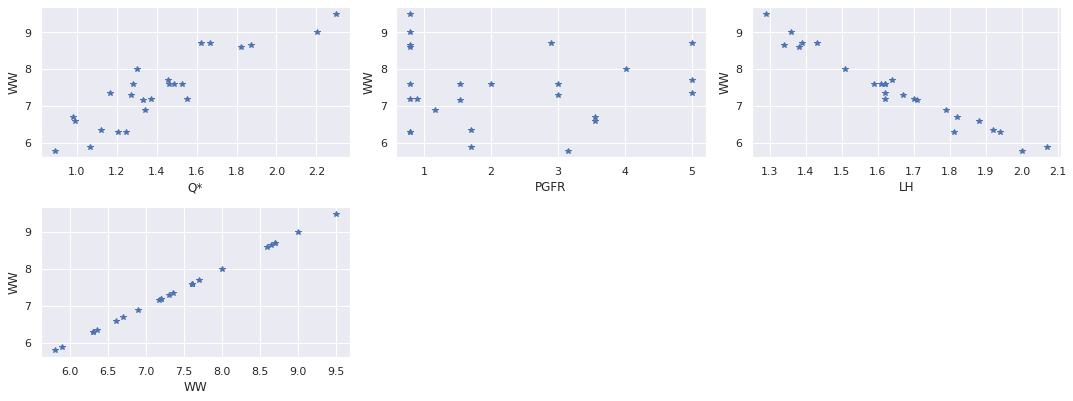

In [ ]:
fields = ['Q*','PGFR','LH','WW']
import seaborn as sns
sns.set()

fig = plt.figure()
fig.set_size_inches((15,8))
for i, field in enumerate(fields):
  plt.subplot(3, 3, i + 1)
  plt.plot(data[field], data['WW'], 'b*')
  plt.xlabel(field)
  plt.ylabel('WW')

plt.tight_layout()

X=data[['Q*','PGFR']]
Y=data['WW'][:,None]
Z=data['LH'][:,None]


#fig.tight_layout()

NameError: ignored

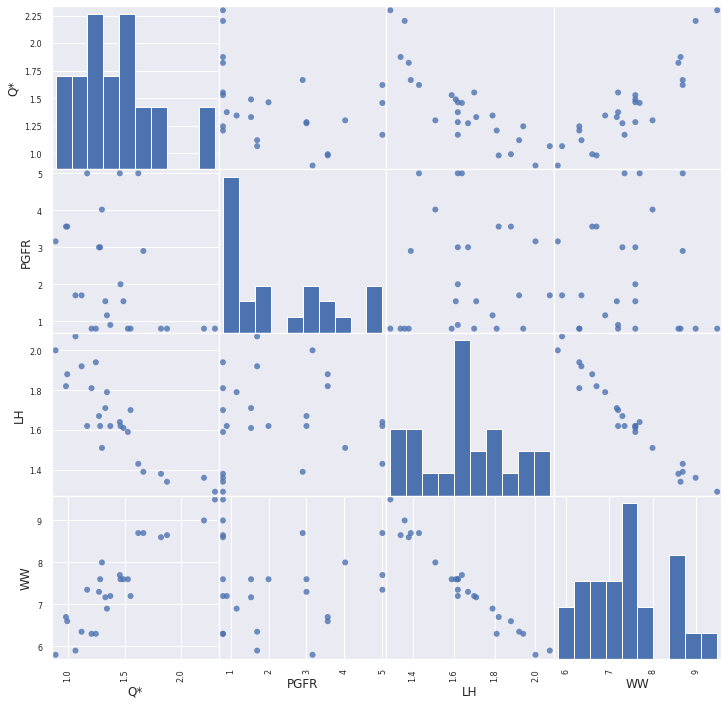

In [ ]:
from pandas.plotting import scatter_matrix
#DISPLAY MATRIX - identificar correlacion entre variables
scatter_matrix(data, alpha=0.8, marker='o', figsize = (12,12))
warnings.filterwarnings("ignore")

#Wall width prediction

In [ ]:
def normalize(X, X_mu, X_std):
  return (X - X_mu)/X_std

def denormalize(Xn, X_mu, X_std):
  return Xn*X_std + X_mu

X_std = X.std(0)
X_mu = X.mean(0)
Xn = normalize(X, X_mu, X_std)

Y_std = Y.std(0)
Y_mu = Y.mean(0)
Yn = normalize(Y, Y_mu, Y_std)

 Split data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.22, random_state=32)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 19  test samples: 6


In [ ]:
pip install lazypredict

In [ ]:
from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.utils import shuffle
import numpy as np

#Conclusions:

In [ ]:
from sklearn.metrics import mean_absolute_error as MAE
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 39/39 [00:00<00:00, 50.86it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'
[01:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
                               R-Squared  RMSE  Time Taken
Model                                                     
SGDRegressor                        0.86  0.27        0.01
LinearSVR                           0.84  0.29        0.01
ElasticNetCV                        0.74  0.37        0.04
Ridge                               0.74  0.37        0.01
RidgeCV                             0.74  0.37        0.01
BayesianRidge                       0.74  0.37        0.01
LassoCV                             0.74  0.37        0.07
Lars                                0.74  0.37        0.01
OrthogonalMatchingPursuitCV         0.74  0.37        0.01
LinearRegression                    0.74  0.37        0.01
LassoLarsIC                         0.74  0.37        0.01


## Gradien boosting regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
#HYPERPARAMETERS

params = {'n_estimators': 3000, 'max_depth': 40, 'min_samples_split': 6, 'max_leaf_nodes': 20,
          'learning_rate': 0.01, 'random_state': 32,'loss': 'ls'}
#KERNEL
model = GradientBoostingRegressor(**params)
#TRAIN
model.fit(X_train,y_train)

#TESTING
y_star_train = model.predict(X_train)
#y_star_val = model1.predict(X_val)
y_pred = model.predict(X_test)

#Plots
plt.figure()
plt.plot(y_train, y_star_train, 'b.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')
plt.title('Gradient boosting regressor')
plt.figure()
plt.plot(y_test, y_pred, 'r*')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
plt.title('Gradient boosting regressor') 

In [ ]:
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)
MSE_train = MSE(y_train, y_star_train)
 
print("-Gradient boosting regressor-")
print("-----------------------------")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

#GBR 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
#KERNEL
#GBR=GradientBoostingRegressor(n_estimators=100, random_state=0)
GBR=GradientBoostingRegressor(n_estimators=100, random_state=32, learning_rate=0.1, )

#START TRAINING
GBR.fit(X_train,y_train)
#PREDICTION
y_pred=GBR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

 
print("-Gradient boosting regressor-")
print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)


-Gradient boosting regressor-
-----------------------------
MSE test: 0.05956374074163193

R2:  0.8873794817910321
RMSE:  0.24405683916176563
MAE:  0.20991875048319356
IM:  0.341046922970599

Relative error (%):  [[3.96545141e+00 1.08739312e-02 2.14827386e+01 4.04633681e+00
  6.45811312e+00 1.78769593e+01]
 [5.33341788e+00 1.30477246e+00 2.04496167e+01 2.78378861e+00
  5.22729881e+00 1.67963930e+01]
 [3.80230993e+01 3.27441846e+01 4.23843324e+00 2.73867598e+01
  2.41849188e+01 9.02541609e+00]
 [1.11852744e+01 6.93281538e+00 1.60301510e+01 2.61711202e+00
  3.78512514e-02 1.21739704e+01]
 [5.33341788e+00 1.30477246e+00 2.04496167e+01 2.78378861e+00
  5.22729881e+00 1.67963930e+01]
 [2.70688851e+01 2.22089319e+01 4.03445829e+00 1.72766995e+01
  1.43289729e+01 3.72605289e-01]]


In [ ]:
#Plots
y_hat=GBR.predict(X)

fig = plt.figure()
fig.set_size_inches((9,6))

plt.plot(Y, y_hat, 'r*')
plt.plot([y_hat.min(), y_hat.max()], [y_hat.min(), y_hat.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
plt.title('Gradient boosting regressor') 



# GPs

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
model=GPR(kernel=kernel, n_restarts_optimizer=9, alpha=0.01, normalize_y=True)
 
#Training
model.fit(X_train,y_train)
 
#Testing
y_star_train = model.predict(X_train)
y_pred = model.predict(X_test)
 
#Plots
plt.figure()
plt.plot(y_train, y_star_train, 'g.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')

plt.figure()
plt.plot(y_test, y_pred, 'r*')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gaussian Process")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)
print()
""" 
RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)
"""
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

# SGD

In [ ]:
from sklearn.linear_model import SGDRegressor

print("-SGD regressor-")
#KERNEL
#SGD=SGDRegressor(random_state=32, max_iter=1000, tol=1e-3, loss='squared_loss', penalty='l2')
from sklearn.ensemble import RandomForestRegressor
#KERNEL
SGD=RandomForestRegressor(n_estimators=500,max_depth=10)


#START TRAINING
SGD.fit(X_train,y_train)
#PREDICTION
y_pred=SGD.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

# XGB

In [ ]:
import pickle
import xgboost as xgb

xgbr = xgb.XGBRegressor(verbosity=0)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [ ]:
print(xgbr)



In [ ]:
score = xgbr.score(X_test, y_test)  
print("Training score: ", score)

In [ ]:
print("-XGBRegressor -")
print("------------------")

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

print(" AdaBoost -")
print("------------------")

Ada = AdaBoostRegressor(random_state=32, n_estimators=100)
#START TRAINING
Ada.fit(X_train,y_train)
#PREDICTION
y_pred=Ada.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

## Comparisson

In [ ]:
models = [GBR, xgbr, Ada, SGD]
labels = ['GBR', 'SGD', 'XGBR', 'AdaBoost']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X)
  plt.plot(Y, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
plt.legend()  
  